### Content
- adversarial detection on CIFAR-10
  - [ ] illustrate detection + correction: figure 1
  - [ ] compute some numbers from the tables + ROC curves
  - [ ] comparison with MSE (incl. ROC curve?!)
- concept drift on CIFAR-10-C
  - [ ] incl. figure 7
- [ ] detection system performance

### TODO
#### Datasets, models and fetch fn
- [x] upload C&W + SLIDE attack datasets (train + test) on CIFAR-10 classifiers to bucket
- [x] upload pretrained ResNet-56 and simple CNN classifiers on CIFAR-10 to bucket
- [x] upload pre-trained detectors for KL, T-scaling and hidden K-L for both classifiers
- [x] upload CIFAR-10-C to bucket + fetch fn
- [ ] generic fetch_fn for ad and od for detectors in the bucket
- [x] fetch fn for attacks in the bucket

# Adversarial AE detection and correction on CIFAR-10

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tqdm import tqdm

from alibi_detect.ad import AdversarialAE
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_attack, fetch_cifar10c, corruption_types_cifar10c
from tensorflow.python.keras import backend

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Utility functions

In [52]:
def scale_by_instance(X: np.ndarray) -> np.ndarray:
    mean_ = X.mean(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    std_ = X.std(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
    return (X - mean_) / std_, mean_, std_


def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (y_true == y_pred).astype(int).sum() / y_true.shape[0]


def predict_batch(model: tf.keras.Model, 
                  X: np.ndarray, 
                  batch_size: int = 32, 
                  recon: bool = False,
                  proba: bool = False,
                  n_categories: int = 10) -> np.ndarray:
    n = X.shape[0]
    if recon:
        shape = X.shape
        dtype = np.float32
    elif proba:
        shape = (n, n_categories)
        dtype = np.float32
    else:
        shape = (n,)
        dtype = np.int64
    preds = np.zeros(shape, dtype=dtype)
    n_minibatch = int(np.ceil(n / batch_size))
    for i in tqdm(range(n_minibatch)):
        istart, istop = i * batch_size, min((i + 1) * batch_size, n)
        if recon:
            preds[istart:istop] = model(X[istart:istop]).numpy()
        elif proba:
            preds[istart:istop] = model(X[istart:istop]).numpy()
        else:
            preds[istart:istop] = model(X[istart:istop]).numpy().argmax(axis=-1)
    return preds

def plot_adversarial(idx: list,
                     X: np.ndarray,
                     y: np.ndarray,
                     X_adv: np.ndarray, 
                     y_adv: np.ndarray,
                     mean: np.ndarray, 
                     std: np.ndarray, 
                     score_x: np.ndarray = None,
                     score_x_adv: np.ndarray = None,
                     X_recon: np.ndarray = None,
                     y_recon: np.ndarray = None,
                     figsize: tuple = (10, 5)) -> None:
    
    # category map from class numbers to names
    cifar10_map = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                   6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
    
    nrows = len(idx)
    ncols = 3 if X_recon else 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    n_subplot = 1
    for i in idx:
        
        # rescale images in [0, 1]
        X_adj = (X[i] * std[i] + mean[i]) / 255
        X_adv_adj = (X_adv[i] * std[i] + mean[i]) / 255
        if X_recon:
            X_recon_adj = (X_recon[i] * std[i] + mean[i]) / 255
        
        # original image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if score_x:
                plt.title('CIFAR-10 Image \n{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('CIFAR-10 Image \n{}'.format(cifar10_map[y[i]]))
        else:
            if score_x:
                plt.title('{}: {:.3f}'.format(cifar10_map[y[i]], score_x[i]))
            else:
                plt.title('{}'.format(cifar10_map[y[i]]))
        plt.imshow(X_adj)
        n_subplot += 1
        
        # adversarial image
        plt.subplot(nrows, ncols, n_subplot)
        plt.axis('off')
        if i == idx[0]:
            if score_x_adv:
                plt.title('Adversarial \n{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('Adversarial \n{}'.format(cifar10_map[y_adv[i]]))
        else:
            if score_x_adv:
                plt.title('{}: {:.3f}'.format(cifar10_map[y_adv[i]], score_x_adv[i]))
            else:
                plt.title('{}'.format(cifar10_map[y_adv[i]]))
        plt.imshow(X_adv_adj)
        n_subplot += 1
     
        # reconstructed image
        if X_recon:
            plt.subplot(nrows, ncols, n_subplot)
            plt.axis('off')
            if i == idx[0]:
                plt.title('AE Reconstruction \n{}'.format(cifar10_map[y_recon[i]]))
            else:
                plt.title('{}'.format(cifar10_map[y_recon[i]]))
            plt.imshow(X_recon_adj)
            n_subplot += 1
    
    plt.show()

### Load data

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

Standardise the dataset by instance:

In [4]:
X_train, mean_train, std_train = scale_by_instance(X_train)
X_test, mean_test, std_test = scale_by_instance(X_test)
scale = (mean_train, std_train), (mean_test, std_test)

### Load classifier

$TODO$: add fetch fn for model! 

In [5]:
clf_path = '../../../adversarial_img/resnet56/'
clf = tf.keras.models.load_model(clf_path + 'model.h5', custom_objects={'backend': backend})

/home/avl/anaconda3/envs/detect/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/core.py:986: UserWarning: official.vision.image_classification.resnet_cifar_model is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Check that the predictions on the test set reach $93.15$% accuracy:

In [6]:
y_pred = predict_batch(clf, X_test, batch_size=32, recon=False)

100%|██████████| 313/313 [00:18<00:00, 16.62it/s]


In [7]:
acc_y_pred = accuracy(y_test, y_pred)
print('Accuracy: {:.4f}'.format(acc_y_pred))

Accuracy: 0.9315


### Adversarial Attack

We investigate both [Carlini-Wagner (C&W)](https://arxiv.org/abs/1608.04644) and [SLIDE](https://arxiv.org/abs/1904.13000) attacks. You can either load previously found adversarial instances on the ResNet-56 model or launch a new attack:

In [8]:
dataset = 'cifar10'
model = 'resnet56'

In [12]:
# C&W attack
data_cw = fetch_attack(dataset, model, 'cw')
X_train_cw, X_test_cw = data_cw['data_train'], data_cw['data_test']
meta_cw = data_cw['meta'] # metadata with hyperparameters of the attack
# SLIDE attack
data_slide = fetch_attack(dataset, model, 'slide')
X_train_slide, X_test_slide = data_slide['data_train'], data_slide['data_test']
meta_slide = data_slide['meta']

In [13]:
print(X_test_cw.shape, X_test_slide.shape)

(10000, 32, 32, 3) (10000, 32, 32, 3)


Check if the prediction accuracy of the model on the adversarial instances is close to $0$%.

In [15]:
y_pred_cw = predict_batch(clf, X_test_cw, batch_size=32, recon=False)
y_pred_slide = predict_batch(clf, X_test_slide, batch_size=32, recon=False)

100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


In [16]:
acc_y_pred_cw = accuracy(y_test, y_pred_cw)
acc_y_pred_slide = accuracy(y_test, y_pred_slide)
print('Accuracy: cw {:.4f} -- SLIDE {:.4f}'.format(acc_y_pred_cw, acc_y_pred_slide))

Accuracy: cw 0.0000 -- SLIDE 0.0002


Let's visualise some adversarial instances:

In [21]:
scale = (mean_train, std_train), (mean_test, std_test)

2

C&W attack...


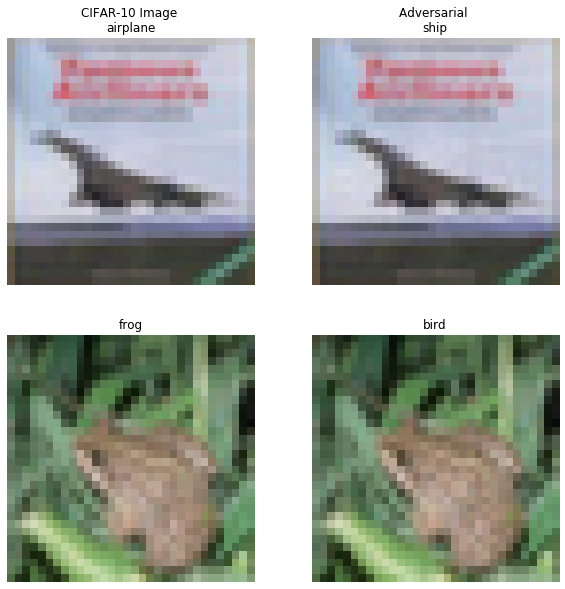

SLIDE attack...


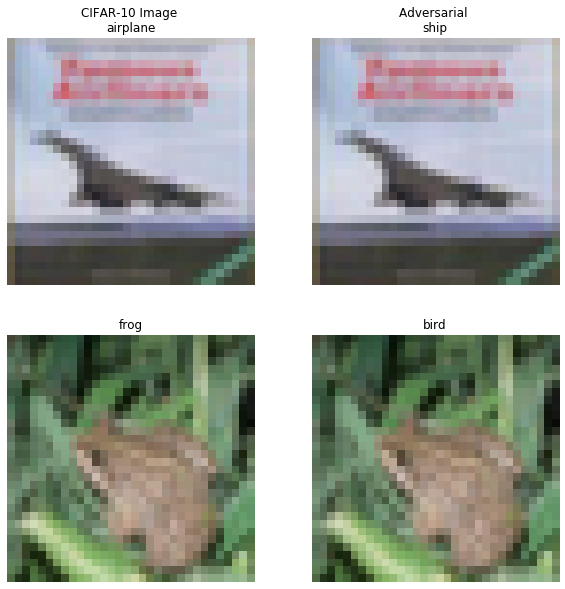

In [61]:
idx = [3, 4]
print('C&W attack...')
plot_adversarial(idx, X_test, y_pred, X_test_cw, y_pred_cw, mean_test, std_test, figsize=(10, 10))
print('SLIDE attack...')
plot_adversarial(idx, X_test, y_pred, X_test_slide, y_pred_slide, mean_test, std_test, figsize=(10, 10))

### Load or train the adversarial detectors

### Test

In [ ]:
corruptions = corruption_types_cifar10c()
print(corruptions)

In [ ]:
X_corr, y_corr = fetch_cifar10c(corruption=corruptions[0], severity=1, return_X_y=True)

In [ ]:
X_corr.shape